In [0]:
import pickle
import pandas as pd
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd '/content/gdrive/My Drive/project-5-Air-Quality-Forecast'

Mounted at /content/gdrive
/content/gdrive/My Drive/project-5-Air-Quality-Forecast


In [3]:
air_df = pickle.load(open("air_df_1.p",'rb'))
open('air_df_1.p','rb').close

<function BufferedReader.close>

In [0]:
air_df.sort_values(by='Date',inplace=True)
df =air_df[['Date','Daily Max 8-hour Ozone Concentration']]
df.set_index('Date',inplace=True)

In [6]:
# import plaidml.keras
# plaidml.keras.install_backend()

import tensorflow as tf

from pathlib import Path
import pandas as pd
import numpy as np
import pandas_profiling
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json

Using TensorFlow backend.


In [0]:
pred_scaler = MinMaxScaler(feature_range = (0, 1))
pred_scaler = pred_scaler.fit(np.array(df['Daily Max 8-hour Ozone Concentration']).reshape(-1, 1))

In [0]:
def plot_loss(history, title):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title(title)
    plt.xlabel('Nb Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
    val_loss = history.history['val_loss']
    min_idx = np.argmin(val_loss)
    min_val_loss = val_loss[min_idx]
    print('Minimum validation loss of {} reached at epoch {}'.format(min_val_loss, min_idx))

In [0]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [10]:
# load dataset
values = df.values
# integer encode direction
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 5)
# drop columns we don't want to predict
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t),var1(t+1),var1(t+2),var1(t+3),var1(t+4)
7,0.246377,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899
8,0.347826,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391
9,0.434783,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391,0.086957
10,0.521739,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391,0.086957,0.014493
11,0.478261,0.391304,0.405797,0.260870,0.043478,0.014493,0.115942,0.202899,0.217391,0.086957,0.014493,0.246377


In [11]:
y = reframed.iloc[:,-1].values
X = reframed.drop(['var1(t)','var1(t+1)','var1(t+2)','var1(t+3)','var1(t+4)'], axis =1).values
# split into train and test sets

n_train_days = 3100
n_test_days=360
train_X = X[:n_train_days,:]
train_y = y[:n_train_days]

val_X= X[n_train_days:-n_test_days,]
val_y= y[n_train_days:-n_test_days]

test_X = X[-n_test_days:,:]
test_y = y[-n_test_days:]



# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,val_X.shape, val_y.shape ,test_X.shape, test_y.shape)

(3100, 1, 7) (3100,) (501, 1, 7) (501,) (360, 1, 7) (360,)


In [0]:
# simple_rnn = Sequential()
# simple_rnn.add(SimpleRNN(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# simple_rnn.add(Dense(1))
# simple_rnn.compile(loss='mae', optimizer=RMSprop())

# #checkpointer = ModelCheckpoint(filepath='simple_rnn_weights.hdf5'
# #                               , verbose=0
# #                               , save_best_only=True)
# earlystopper = EarlyStopping(monitor='val_loss'
#                              , patience=30
#                              , verbose=0)
# with open("simple_rnn.json", "w") as m:
#      m.write(simple_rnn.to_json())

# simple_rnn_history = simple_rnn.fit(train_X,train_y
#                                               , epochs=200
#                                               , validation_data=(val_X, val_y)
#                                               , verbose=2
#                                               , callbacks= [earlystopper]
#                                              )
# plot_loss(simple_rnn_history, 'SimpleRNN - Train & Validation Loss')

In [0]:
# simple_lstm = Sequential()
# simple_lstm.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
# simple_lstm.add(Dense(1))
# simple_lstm.compile(loss='mae', optimizer=RMSprop())

# #checkpointer = ModelCheckpoint(filepath='simple_lstm_weights.hdf5'
# #                               , verbose=0
# #                               , save_best_only=True)
# earlystopper = EarlyStopping(monitor='val_loss'
#                              , patience=30
#                              , verbose=0)
# with open("simple_lstm.json", "w") as m:
#     m.write(simple_lstm.to_json())

# simple_lstm_history = simple_lstm.fit(train_X,train_y
#                                               , epochs=200
#                                               , validation_data=(val_X, val_y)
#                                               , verbose=2
#                                               , callbacks= [earlystopper]
#                                              )
# plot_loss(simple_lstm_history, 'Simple LSTM - Train & Validation Loss')

W0615 22:50:39.822321 140067294779264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0615 22:50:39.839679 140067294779264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0615 22:50:39.842571 140067294779264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0615 22:50:40.368720 140067294779264 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0615 22:50:41.134585 140067294779264 deprecation.py:323

Train on 3100 samples, validate on 501 samples
Epoch 1/200
 - 4s - loss: 0.2486 - val_loss: 0.0928
Epoch 2/200
 - 1s - loss: 0.0908 - val_loss: 0.0883
Epoch 3/200
 - 1s - loss: 0.0881 - val_loss: 0.0880
Epoch 4/200
 - 1s - loss: 0.0870 - val_loss: 0.0862
Epoch 5/200
 - 1s - loss: 0.0866 - val_loss: 0.0852
Epoch 6/200
 - 1s - loss: 0.0862 - val_loss: 0.0853
Epoch 7/200
 - 1s - loss: 0.0863 - val_loss: 0.0861
Epoch 8/200
 - 1s - loss: 0.0863 - val_loss: 0.0854
Epoch 9/200
 - 1s - loss: 0.0864 - val_loss: 0.0848
Epoch 10/200
 - 1s - loss: 0.0863 - val_loss: 0.0851
Epoch 11/200
 - 1s - loss: 0.0863 - val_loss: 0.0847
Epoch 12/200
 - 1s - loss: 0.0862 - val_loss: 0.0848
Epoch 13/200
 - 1s - loss: 0.0861 - val_loss: 0.0857
Epoch 14/200
 - 1s - loss: 0.0862 - val_loss: 0.0860
Epoch 15/200
 - 1s - loss: 0.0864 - val_loss: 0.0847
Epoch 16/200
 - 1s - loss: 0.0862 - val_loss: 0.0857
Epoch 17/200
 - 1s - loss: 0.0863 - val_loss: 0.0849
Epoch 18/200
 - 1s - loss: 0.0863 - val_loss: 0.0849
Epoch 19

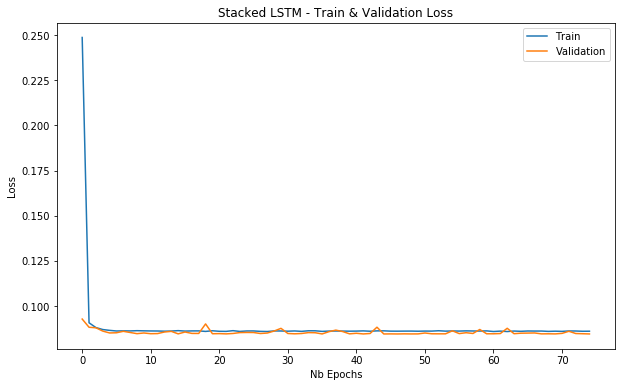

Minimum validation loss of 0.08459200289197073 reached at epoch 44


In [14]:
stacked_lstm = Sequential()
stacked_lstm.add(LSTM(16, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
stacked_lstm.add(LSTM(8, return_sequences=True))
stacked_lstm.add(LSTM(4))
stacked_lstm.add(Dense(1))
stacked_lstm.compile(loss='mae', optimizer=RMSprop())

#checkpointer = ModelCheckpoint(filepath='stacked_lstm_weights.hdf5'
#                               , verbose=0
#                               , save_best_only=True)
earlystopper = EarlyStopping(monitor='val_loss'
                             , patience=30
                             , verbose=0)
with open("stacked_lstm.json", "w") as m:
    m.write(stacked_lstm.to_json())

stacked_lstm_history = stacked_lstm.fit(train_X,train_y
                                              , epochs=200
                                              , validation_data=(val_X, val_y)
                                              , verbose=2
                                              , callbacks= [earlystopper]
                                             )
plot_loss(stacked_lstm_history, 'Stacked LSTM - Train & Validation Loss')

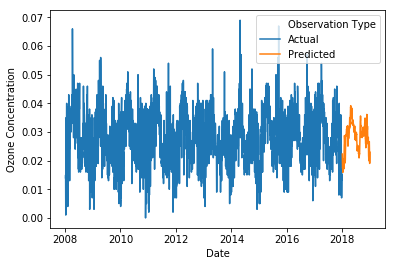

In [15]:
preds = []
preds_array = stacked_lstm.predict(test_X)
for i in range(len(preds_array)):
    preds.append(preds_array[i][0])

train_data = pd.DataFrame({
    'Ozone Concentration':train_y,
    'Date':df.index[7:3107]
})
train_data['Observation Type'] = 'Actual'

val_data = pd.DataFrame({
    'Ozone Concentration':val_y,
    'Date':df.index[3107:-364]
})
val_data['Observation Type'] = 'Actual'

test_data = pd.DataFrame({
    'Ozone Concentration':preds,
    'Date':df.index[-360:]
})
test_data['Observation Type'] = 'Predicted'

plot_me = pd.concat([train_data,val_data,test_data])
plot_me['Ozone Concentration'] = pred_scaler.inverse_transform(np.array(plot_me['Ozone Concentration']).reshape(-1, 1))
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])

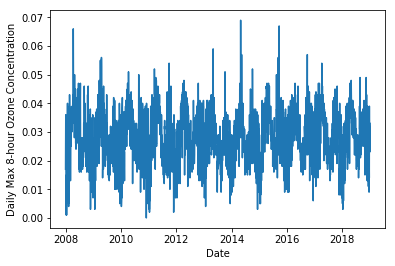

In [16]:
sns.lineplot(x=df.index,y=df['Daily Max 8-hour Ozone Concentration'])

In [0]:
sns.set_style('whitegrid')
sns.set_context('talk')


plt.figure(figsize=(10,2))


plt.subplot(2,1,2)
plt.title('Historical Data')
sns.lineplot(x=df.index,y=df['Daily Max 8-hour Ozone Concentration'])
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))   
plt.ylabel('Ozone Concentration')


plt.subplot(2,1,1)
plt.title('Five Day Forward Forecasts - Univariate-LSTM')
sns.lineplot(x=plot_me.Date,y=plot_me['Ozone Concentration'],hue=plot_me['Observation Type'])
plt.legend(loc='upper left')
plt.xlim((pd.to_datetime('2017-01-01'),pd.to_datetime('2019-01-01')))  
plt.ylabel('Ozone Concentration')
plt.subplots_adjust(left=None, bottom= -4, right=None, top=None, wspace=None, hspace=None)
plt.xlabel('')


plt.savefig('forecasts/single5day.png',bbox_inches="tight")